In [2]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

import sys
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#font = {'size'   : 14}
#mpl.rc('font', **font)

import numpy as np
import pandas as pd

import scipy
from scipy import stats

import sklearn
import sklearn.cluster
import sklearn.datasets

import phate
import umap
import scprep
import magic
import meld
import graphtools as gt



<a id='loading'></a>
# 1. Loading preprocessed data

### Load EB Data (and download if needed)

In [3]:
home = os.path.expanduser('~')
file_path = os.path.join(home, 'scRNAseq', 'EBT_counts.pkl.gz')
if not os.path.exists(file_path):
    scprep.io.download.download_google_drive(id='1Xz0ONnRWp2MLC_R6r74MzNwaZ4DkQPcM',
                        destination=os.path.dirname(file_path))
EBT_counts = pd.read_pickle(file_path)

In [4]:
EBT_counts.head()

,FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP11-206L10.9 (ENSG00000237491),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),RP11-54O7.1 (ENSG00000230699),RP11-54O7.2 (ENSG00000241180),RP11-54O7.3 (ENSG00000223764),SAMD11 (ENSG00000187634),NOC2L (ENSG00000188976),...,MT-ND4L (ENSG00000212907),MT-ND4 (ENSG00000198886),MT-ND5 (ENSG00000198786),MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),AC011043.1 (ENSG00000276256),AL592183.1 (ENSG00000273748),AC007325.4 (ENSG00000278817),AC004556.1 (ENSG00000276345),AC240274.1 (ENSG00000271254)
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.288398,1.898557,0.000000,3.797115,0.0,0.0,0.0,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.931534,...,0.0,3.158984,1.140891,0.658694,3.293468,0.0,0.0,0.0,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.282188,1.432464,0.000000,4.237287,0.0,0.0,0.0,0.0,0.0
AAAGATCTCTGCTC-1_Day 00-03,0.0,1.232158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.141399,0.871267,0.000000,4.086606,0.0,0.0,0.0,0.0,0.0
AAAGATCTGGTACT-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.686594,...,0.0,2.912970,0.970990,0.000000,3.760628,0.0,0.0,0.0,0.0,0.0


In [5]:
data = pd.read_pickle('/home/dan/scRNAseq/EBT_counts.pkl.gz')

# 2. Imputation using MAGIC

As we mentioned, because scRNA-seq, suffers from dropout (the undercounting of mRNA molecules in single cells), examining expression lowly expressed genes can be challenging. To overcome this, we developed a method for imputation called MAGIC (Markov Affinity Graph Imputation in Cells; [PMID: 29961576 ](https://www.ncbi.nlm.nih.gov/pubmed/29961576)). 

Without going into too much detail about how it works, the basic idea is that although gene expression counts in each cell are unreliable, the gene expression counts matrix contains several degrees of redundancy between genes (i.e. expression of genes is not completely indepdent) and among cells (i.e. we see very similar cells more than once).

A full description of MAGIC can be found in the paper, and on our website: [Denoising and imputing scRNA-seq data](https://www.krishnaswamylab.org/blog/2018/10/28/denoising-noisy-gene-expression-in-scrna-seq).

#### Running MAGIC

Because MAGIC returns a dense matrix (many zeros in the counts matrix are removed), we only want to keep expression of a few marker genes. The list in the following cell was gathering while analyzing the data, and we'll look at them later.



In [6]:
full_marker_genes = ['ARID3A (ENSG00000116017)', 'ASCL2 (ENSG00000183734)',  'CD34 (ENSG00000174059)',
 'CDX2 (ENSG00000165556)', 'CER1 (ENSG00000147869)', 'DLX1 (ENSG00000144355)',
 'DMRT3 (ENSG00000064218)', 'EN2 (ENSG00000164778)', 'EOMES (ENSG00000163508)',
 'FOXA2 (ENSG00000125798)', 'FOXD3-AS1 (ENSG00000230798)', 'GATA3-AS1 (ENSG00000197308)',
 'GATA4 (ENSG00000136574)', 'GATA5 (ENSG00000130700)', 'GATA6-AS1 (ENSG00000266010)',
 'GBX2 (ENSG00000168505)', 'GLI3 (ENSG00000106571)', 'HOXA2 (ENSG00000105996)',
 'HOXB1 (ENSG00000120094)', 'HOXB4 (ENSG00000182742)', 'HOXD13 (ENSG00000128714)',
 'HOXD9 (ENSG00000128709)', 'ISL1 (ENSG00000016082)', 'KLF5 (ENSG00000102554)',
 'KLF7 (ENSG00000118263)', 'LEF1 (ENSG00000138795)', 'LHX2 (ENSG00000106689)',
 'LHX5 (ENSG00000089116)', 'LMX1A (ENSG00000162761)', 'MAP2 (ENSG00000078018)',
 'MIXL1 (ENSG00000185155)', 'MYCBP (ENSG00000214114)', 'NANOG (ENSG00000111704)',
 'NES (ENSG00000132688)', 'NKX2-1 (ENSG00000136352)', 'NKX2-5 (ENSG00000183072)',
 'NKX2-8 (ENSG00000136327)', 'NPAS1 (ENSG00000130751)', 'NR2F1-AS1 (ENSG00000237187)',
 'OLIG1 (ENSG00000184221)', 'OLIG3 (ENSG00000177468)', 'ONECUT1 (ENSG00000169856)',
 'ONECUT2 (ENSG00000119547)', 'OTX2 (ENSG00000165588)', 'PAX3 (ENSG00000135903)',
 'PAX6 (ENSG00000007372)', 'PDGFRA (ENSG00000134853)', 'PECAM1 (ENSG00000261371)',
 'POU5F1 (ENSG00000204531)', 'SATB1 (ENSG00000182568)', 'SIX2 (ENSG00000170577)',
 'SIX3-AS1 (ENSG00000236502)', 'SIX6 (ENSG00000184302)', 'SOX13 (ENSG00000143842)',
 'SOX10 (ENSG00000100146)', 'SOX15 (ENSG00000129194)', 'SOX17 (ENSG00000164736)',
 'SOX9 (ENSG00000125398)', 'TTLL10 (ENSG00000162571)', 'TAL1 (ENSG00000162367)',
 'TBX15 (ENSG00000092607)', 'TBX18 (ENSG00000112837)', 'TBX5 (ENSG00000089225)',
 'TNNT2 (ENSG00000118194)', 'WT1 (ENSG00000184937)', 'ZBTB16 (ENSG00000109906)',
 'ZIC2 (ENSG00000043355)', 'ZIC5 (ENSG00000139800)', 'ACTB (ENSG00000075624)',
 'HAND1 (ENSG00000113196)']

In [8]:
data_magic = magic.MAGIC().fit_transform(data, genes=full_marker_genes)

Calculating MAGIC...
  Running MAGIC on 16821 cells and 17619 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.43 seconds.
    Calculating KNN search...
    Calculated KNN search in 33.33 seconds.
    Calculating affinities...
    Calculated affinities in 14.07 seconds.
  Calculated graph and diffusion operator in 57.08 seconds.
  Calculating imputation...
    Automatically selected t = 10
  Calculated imputation in 3.01 seconds.
Calculated MAGIC in 66.22 seconds.


In [9]:
data_magic.head()

,TTLL10 (ENSG00000162571),MYCBP (ENSG00000214114),TAL1 (ENSG00000162367),FOXD3-AS1 (ENSG00000230798),TBX15 (ENSG00000092607),NES (ENSG00000132688),LMX1A (ENSG00000162761),TNNT2 (ENSG00000118194),SOX13 (ENSG00000143842),CD34 (ENSG00000174059),...,PECAM1 (ENSG00000261371),SOX9 (ENSG00000125398),GATA6-AS1 (ENSG00000266010),ONECUT2 (ENSG00000119547),FOXA2 (ENSG00000125798),GATA5 (ENSG00000130700),ARID3A (ENSG00000116017),NPAS1 (ENSG00000130751),SOX10 (ENSG00000100146),OLIG1 (ENSG00000184221)
AAACCGTGCAGAAA-1_Day 00-03,0.001594,0.143290,-0.000345,0.119123,-0.000545,0.179997,0.014960,0.005589,0.032402,0.000447,...,-0.000082,0.048531,0.005479,0.004824,0.003461,0.007651,0.102569,0.035377,0.009680,0.003592
AAACGCACCGGTAT-1_Day 00-03,0.002455,0.175532,-0.000340,0.721887,0.001475,0.101670,-0.002042,0.040391,0.045600,-0.001450,...,0.000004,0.011722,0.009977,0.007995,0.006222,-0.000564,0.115948,0.051247,-0.000588,0.000898
AAACGCACCTATTC-1_Day 00-03,0.002530,0.176799,0.000358,0.728740,0.001510,0.109729,-0.000901,0.022619,0.044177,-0.000943,...,-0.000064,0.017240,0.001117,0.007778,0.007841,-0.001639,0.109978,0.049576,0.002403,-0.000189
AAAGATCTCTGCTC-1_Day 00-03,0.001809,0.133314,-0.000375,0.087182,-0.000341,0.180440,0.019858,0.006797,0.030842,0.000252,...,-0.000419,0.043456,0.002414,0.004511,0.003149,0.007003,0.098509,0.036954,0.007529,0.008883
AAAGATCTGGTACT-1_Day 00-03,0.002401,0.175370,-0.000406,0.724121,0.001417,0.100354,-0.002199,0.042959,0.045676,-0.001585,...,-0.000051,0.010509,0.010503,0.008053,0.005782,-0.000571,0.115953,0.051093,-0.000937,0.000881


# 3. Visualizing the data

We've already spent time discussing visualizations of this data using 

# 4. Clustering

## 4.1 Introduction to clustering

#### What is clustering?

The goal of clustering is to identify a partition of the data such that all of the observations within each partition (called a cluster) are more similar to each other than they are to those in other clusters. Many clustering algorithms exist, and they each have their own quirks (just like visualization algorithms). `sklearn` has implementations for some of the most popular ones and their [User Guide on Clustering](https://scikit-learn.org/stable/modules/clustering.html) is a good resource to understand general clustering approaches.

To understand how clustering works, let's start with a simple algorithm called k-means. Here, `k` refers to the number of clusters in the dataset. (Note: The following images and algorithm description are adapted from the book *Doing Data Science* by Cathy O'Neil and Rachel Schutt. I highly reccomend this book, especially the first few chapters. It provides a great introduction into some common frameworks in data analysis).

In a dataset like the following, it's probably easy to see that `k` should be set to 3.
  
<br>

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/kmeans_tutorial_1.png" style="height: 20rem;"/>



The steps of the k-means algorithm are as follows:
1. Initially, randomly pick `k` centroids.
2. Assign each data point to the closest centroid.
3. Move the centroids to the average location of the data points assigned to it.
4. Repeat the Steps 1-3 until the assignments don’t change, or change very little. This is called convergence.

Let's start by looking at the first two steps of the algorithm.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/kmeans_tutorial_2.png" style="height: 43rem;"/>








In the top frame, you can see three centroids being randomly initialized. This is Step 1.

In the bottom frame (Step 2), all of the points get assigned to the closest centroid and adopt that centroid's cluster identity (marked here by color).

Now, we proceed to Step 3 where the centroids get moved to the average location of the data points. Here the centroids are outlined in black for clarity.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/kmeans_tutorial_3.png" style="height: 21rem;"/>


Finally, we reassign points to the closest cluster centroid.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/kmeans_tutorial_4.png" style="height: 21rem;"/>

These cluster assignments are now fairly good. The algorithm needs to be run a few more rounds in order to realize that it has "converged", but the cluster assignments and centroids won't change very much.

## 4.2 Clustering single cell data

#### Clustering methods for single cell RNA-seq

Although k-means is a very powerful algorithm, it has many flaws. This blog post: ["k-means clustering is not a free lunch"](https://www.r-bloggers.com/k-means-clustering-is-not-a-free-lunch/) does a good job of explaining several of the big ones. As a result, several domain-specific clustering algorithms have been developed for single cell data. [SNN-cliq](https://www.ncbi.nlm.nih.gov/pubmed/25805722), sometimes misattributed as "Seurat clustering" (although the algorithm was not developed by that group, just implemented in R by them), identifies sets of cells that have shared nearest neighbors. The louvain clustering algorithm, published with some modifications under the name [Phenograph](https://www.ncbi.nlm.nih.gov/pubmed/26095251), is another popular graph clustering algorithm.

Here, we're going to focus on an algorithm developed by the Krishnaswamy lab that uses the diffusion potential learned by PHATE to identify cells with similar transcriptome profiles. You'll notice that we use k-means here, but this is not done on the data space (i.e. on the genes in each cell). Rather we run k-means on the diffusion potential, which represents the affinity between cells. In this sense, the approach is similar to [Spectral Clustering](https://dl.acm.org/citation.cfm?id=2980649).

#### Using PHATE clustering

The API for PHATE clustering is very simple. You just pass the clustering method the `phate_op` and set `k` and it returns an array of cluster assignments.

In [0]:
k = 18
clusters = phate.cluster.kmeans(phate_op=phate_op, k=k, random_state=42)

In [0]:
import seaborn as sns

In [0]:
# This line generates a dictionary with a single color associated with each
# cluster label in `clusters`
cluster_cmap = {cl:sns.husl_palette(k)[cl] for cl in np.unique(clusters)}
cluster_cmap

{0: [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 1: [0.9707505829046977, 0.4626541987597626, 0.26486329418330007],
 2: [0.8369430560927636, 0.5495828952802333, 0.1952683223448124],
 3: [0.7350228985632719, 0.5952719904750953, 0.1944419133847522],
 4: [0.6430915736746491, 0.6271955086583126, 0.19381135329796756],
 5: [0.5310702086647983, 0.6569113639885688, 0.1931838276161326],
 6: [0.3126890019504329, 0.6928754610296064, 0.1923704830330379],
 7: [0.1998437102815942, 0.6927711055021983, 0.4485948481767363],
 8: [0.20582072623426667, 0.6842209016721069, 0.5675558225732941],
 9: [0.21044753832183283, 0.6773105080456748, 0.6433941168468681],
 10: [0.2151139535594307, 0.6700707833028816, 0.7112365203426209],
 11: [0.22126158707091403, 0.6600977737826563, 0.7915486637100363],
 12: [0.23299120924703914, 0.639586552066035, 0.9260706093977744],
 13: [0.5392573577708815, 0.5821140171749066, 0.9584212824085171],
 14: [0.731751635642941, 0.5128186367840487, 0.9581005178234921],


#### Plotting clusters with PHATE

Above, we colored our scatter plots using expression of a marker gene. However, we can use any information with one value per cell to color the plot. Here, we're using the cluster identity.

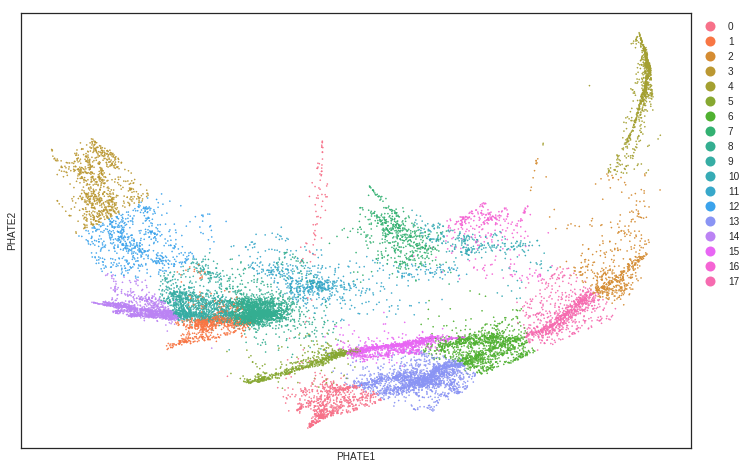

In [0]:
scprep.plot.scatter2d(data_phate, c=clusters, figsize=(12,8), cmap=cluster_cmap,
                      ticks=False, label_prefix="PHATE", legend_anchor=(1,1))

We can also plot each cluster individually to see where they are on the PHATE plot




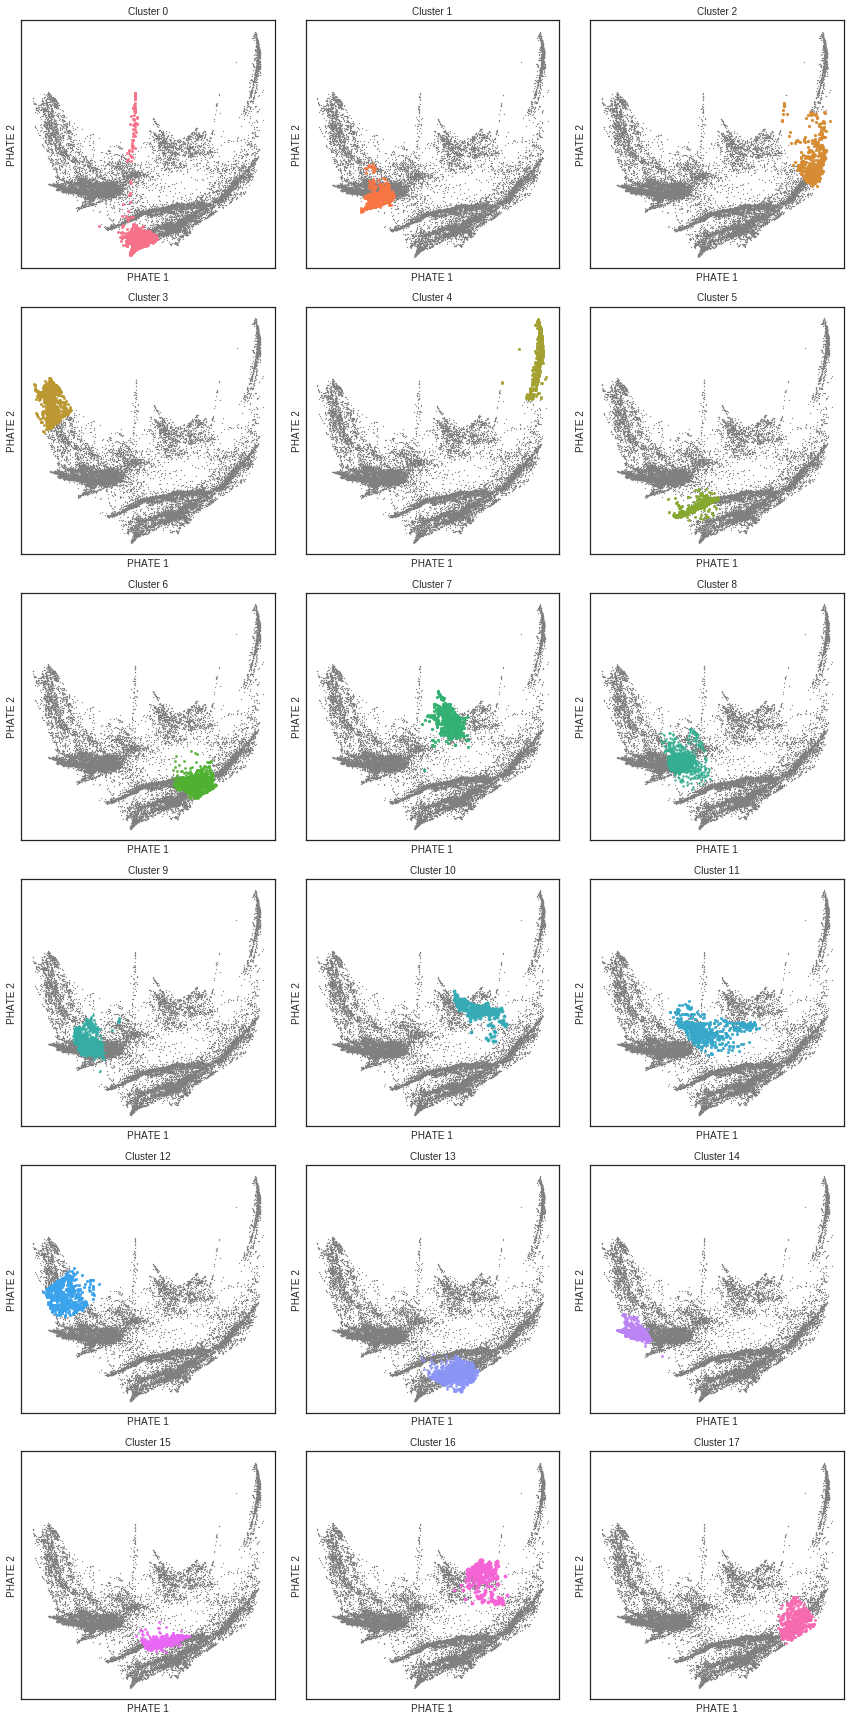

In [0]:
n_rows = 6
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*4))
axes = axes.flatten()

for i, ax in enumerate(axes):
    try:
      curr_cluster = np.unique(clusters)[i]
    except IndexError:
      ax.axis('off')
      continue
    # Returns array([False, True,...,False]) indicating if each cell is in the
    # current cluster
    curr_mask = clusters == curr_cluster  
    scprep.plot.scatter2d(data_phate.loc[~curr_mask] , color='grey', zorder=0, s=1, ax=ax)
    scprep.plot.scatter2d(data_phate.loc[curr_mask], color=cluster_cmap[curr_cluster], title='Cluster {}'.format(curr_cluster),
                          ticks=False, label_prefix='PHATE ', ax=ax)


fig.tight_layout()

In these plots, we can see that each cluster is fairly well localized on the PHATE plot. Now let's figure out what they are!

#### Characterizing clusters

Now, we want to characterize gene expression in each cluster to identify the cell type of that cluster. Cell type is easy to grasp intuitively, but hard to formalize. Generally, we want a cell that expresses a set of genes differently than the rest of the cells in the dataset. As part of writing the PHATE paper, we characterized all the cell types in this time course, and made the following fate map.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/EB_lineage_map.png" style="height: 40rem;"/>

>Lineage tree of the EB system determined from the PHATE analysis showing embryonic stem cells (ESC), the primitive streak (PS), mesoderm  (ME), endoderm (EN), neuroectoderm (NE), neural crest (NC), neural progenitors (NP), lateral plate ME (LP ME), hemangioblast (H), cardiac (C), epicardial precursors (EP), smooth muscle precursors (SMP), cardiac precursors (CP), and neuronal subtypes (NS).

In groups, you need to examine the expression of these sets of genes and figure out which cell type matches your cluster.

#### Jitterplot

The following plot is called a [jitterplot](https://scprep.readthedocs.io/en/stable/examples/jitter.html). This plot is similar to a [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) or a [swarmplot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html), but is computationally cheaper. The goal of this plot is to examine the distribution of values associated with each cell in a set of clusters.

Each point is a cell and the x-axis represents the cluster assignment of that cell. There's a little bit of noise added to the x-position of the cell (that's the jitter). The y-axis represents expression of a given gene.

You can change which gene is plotted by changing the `curr_gene` variable. All of the genes in the above plot will work.

FYI: when a gene is listed as `ZIC2/5`, this actually represents two genes: `ZIC2` and `ZIC5`.

Text(0.5, 1.0, 'POU5F1')

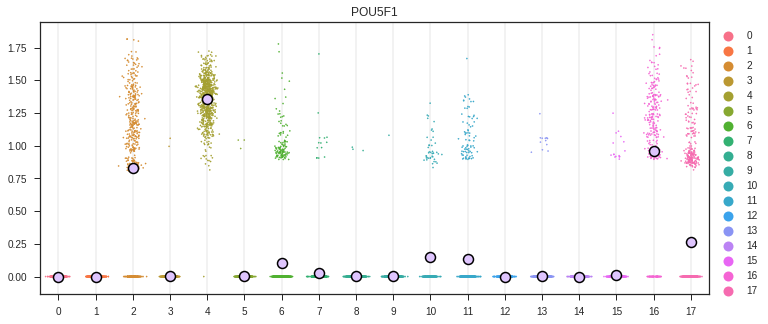

In [0]:
fig, ax = plt.subplots(1, figsize=(12, 5))

curr_gene = 'POU5F1'
curr_expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene)
curr_expression = curr_expression.iloc[:,0]
scprep.plot.jitter(clusters, curr_expression, c=clusters, cmap=cluster_cmap, ax=ax,
                  legend_anchor=(1,1))
ax.set_title(curr_gene)

Text(0.5, 1.0, 'NANOG')

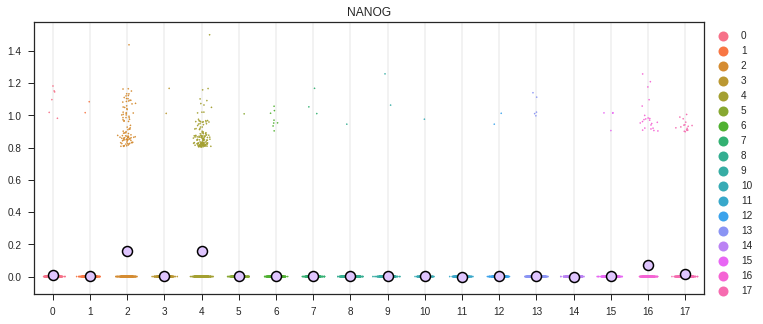

In [0]:
fig, ax = plt.subplots(1, figsize=(12, 5))

curr_gene = 'NANOG'
curr_expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene)
curr_expression = curr_expression.iloc[:,0]
scprep.plot.jitter(clusters, curr_expression, c=clusters, cmap=cluster_cmap, ax=ax,
                  legend_anchor=(1,1))
ax.set_title(curr_gene)

#### Examining expression on PHATE

The other tool you should use for examining clusters is the PHATE plots we used above. You can change the `genes_for_plotting` list, as long as you keep it restricted to three genes.

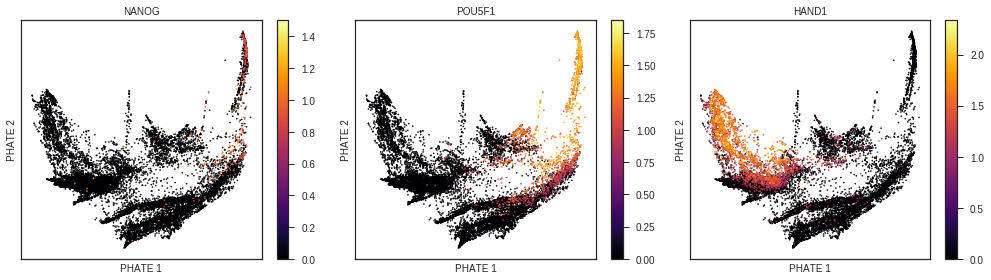

In [0]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()


genes_for_plotting = ['NANOG', 'POU5F1', 'HAND1']

for i, ax in enumerate(axes):
    curr_gene = genes_for_plotting[i]
    

    expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene).to_dense()
    if expression.shape[1] > 1:
      expression = expression[expression.columns[0]]
      expression = pd.DataFrame(expression)
    
    sort_index = expression.sort_values(by=expression.columns[0]).index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='PHATE ', ax=ax)
    
fig.tight_layout()

## Discussion

Now, in your groups, you will be assigned to a cell type from the above lineage map. Please do the following tasks and be prepared to share your conclusions with the rest of the class.
1. Identify which cluster corresponds to your cell type of interest. 
2. Create a PHATE plot that highlights your cells of interest in some way (i.e. shows them in another color). Does this plot make sense with the position of your cell type in the developmental lineage? What information can you learn about your cell type from the PHATE plot?
3. Open coding exercise: Create another plot that shows something interesting about your cell type. This plot should answer a biological question, for example:

      a. Is the expression of marker genes heterogeneous within your cluster?
      
      b. Are your cells present at multiple time points?
      
      c. What other genes are uniquely expressed in your cell type?